# ML Feature enginerring - SelectKbest

In [49]:
%matplotlib inline
%run ../talibref.py
%run ensemble.py
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Get data

In [337]:
#df=pd.read_csv("data/IYZ.csv")
ticker = 'IYE'
startdate=datetime.date(2010, 1, 1)
enddate=datetime.date.today()
df = generate_ticker_data(ticker, startdate, enddate)

Available data: Ticker(IYE) from 2000.06.16 to 2015.11.30
Usable data: Ticker(IYE) from 2001.04.03 to 2015.11.30 
Returned data: Ticker(IYE) from 2010.01.04 to 2015.11.30 
Save path: data/IYE_from_2010.01.04_2015.11.30.csv


In [338]:
dftouse=df.copy()

### Feature Engineering

In [339]:
IGNORE = ['date', 'result_1','close_1','perf_1','result_14','close_14','perf_14','results']

In [340]:
INDICATORS=[]
for v in df.columns:
    l=df[v].unique()
    if len(l) <= 10 and v not in IGNORE:
        #print v, l
        INDICATORS.append(v)

In [341]:
STANDARDIZABLE = []
for v in df.columns:
    if v not in INDICATORS and v not in IGNORE:
        #print v
        STANDARDIZABLE.append(v)

In [342]:
################################################
# Code to add signals from other tickers
################################################

# Additional tickers to consider
moreTickers = [
               '^GSPC', #S&P500
               '^dji',  #Dow Jones Industrials
               '^IXIC', #Nasdaq
               'OIL'   #Oil price ETF
              ]

# Signals for additional tickers
STANDARDIZABLE_TO_ADD = ['roc','stoch_slowk']
INDICATORS_TO_ADD = ['cci_signal']


def addDataFromOtherTicker(tickerPlus):
    dfPlus = generate_ticker_data(tickerPlus, startdate, enddate)
    if df.shape == dfPlus.shape:
        dfPluss = dfPlus.copy()
        dfPluss = dfPluss[STANDARDIZABLE_TO_ADD+INDICATORS_TO_ADD]
        STANDARDIZABLE2 = STANDARDIZABLE_TO_ADD[:]
        INDICATORS2 = INDICATORS_TO_ADD[:]
        for p in STANDARDIZABLE2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]*1.0
            STANDARDIZABLE.append(renamed)
        for p in INDICATORS2:
            renamed = p+'_'+tickerPlus
            dftouse[renamed]=dfPluss[p]
            INDICATORS.append(renamed)
    else:
        print "Data for additional tickers doesn't match data frame for sector of interest."

for tick in moreTickers:
    print "####### Loading data for "+tick+"...."
    addDataFromOtherTicker(tick)    
    time.sleep(0.5)
    
dftouse.head()

####### Loading data for ^GSPC....
Available data: Ticker(^GSPC) from 1950.01.03 to 2015.11.30
Usable data: Ticker(^GSPC) from 1962.05.28 to 2015.11.30 
Returned data: Ticker(^GSPC) from 2010.01.04 to 2015.11.30 
Save path: data/^GSPC_from_2010.01.04_2015.11.30.csv
####### Loading data for ^dji....
Available data: Ticker(^dji) from 1985.01.29 to 2015.11.30
Usable data: Ticker(^dji) from 1987.10.15 to 2015.11.30 
Returned data: Ticker(^dji) from 2010.01.04 to 2015.11.30 
Save path: data/^dji_from_2010.01.04_2015.11.30.csv
####### Loading data for ^IXIC....
Available data: Ticker(^IXIC) from 1971.02.05 to 2015.11.30
Usable data: Ticker(^IXIC) from 1973.11.26 to 2015.11.30 
Returned data: Ticker(^IXIC) from 2010.01.04 to 2015.11.30 
Save path: data/^IXIC_from_2010.01.04_2015.11.30.csv
####### Loading data for OIL....
Available data: Ticker(OIL) from 2006.08.16 to 2015.11.30
Usable data: Ticker(OIL) from 2007.06.05 to 2015.11.30 
Returned data: Ticker(OIL) from 2010.01.04 to 2015.11.30 
Sa

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,33.759998,34.230000,33.740002,34.230000,270500,34.520000,True,0.008472,32.709999,False,-0.044406,1,34.116369,33.1370,32.157631,1.058012,5.911029,False,True,False,0,33.204110,32.709981,34.211016,1,0,32.961746,31.691074,31.398551,1,1,33.012542,1,9.204815,26.977198,20.919486,False,True,0,64,1,165.580551,0,0.120116,0.018719,0.101397,1,0.623534,1,68.627794,0,4.074190,0,61.775320,0,59.334517,0,-0.000000,0,41359.044053,1,46.970847,42.818296,0,100.000000,33.333333,0,0.046332,1,34.066667,36.233335,33.903335,36.396667,31.736667,38.563335,31.573335,1,3.367458,1,2.674556,1,5.888391,1,11.120401,1
1,2010-01-05,34.250000,34.529999,34.110001,34.520000,213800,34.889999,True,0.010718,32.950001,False,-0.045481,0,34.360074,33.2175,32.074927,1.069985,6.879347,False,True,False,0,33.255714,32.733955,34.214091,1,0,32.971973,31.716823,31.449936,1,1,33.182986,1,9.987458,29.616086,19.677589,False,True,0,68,1,197.617175,0,0.193050,0.053585,0.139465,1,0.923815,1,69.049232,0,4.669497,0,64.587626,0,62.644409,0,-0.558604,0,126304.566413,1,67.351254,47.415120,0,100.000000,66.666667,0,0.045918,1,34.386667,36.873333,34.243334,37.016666,31.756668,39.503332,31.613335,1,3.088524,1,2.353882,1,4.386692,1,10.696517,1
2,2010-01-06,34.450001,34.959999,34.360001,34.889999,366600,34.750000,False,-0.004013,32.750000,False,-0.061336,0,34.659760,33.3195,31.979240,1.085893,8.044899,False,True,False,0,33.319803,32.762512,34.220816,1,0,32.986613,31.757440,31.497671,1,1,33.398508,1,11.382671,33.135252,18.030803,False,True,0,72,1,200.319600,0,0.277508,0.098370,0.179138,1,1.244702,1,71.628158,0,4.711882,0,67.838787,0,65.382070,0,-3.153157,0,239000.865162,1,98.404574,70.908892,0,100.000000,100.000000,0,0.046547,1,34.736666,37.573333,34.513334,37.796665,31.676667,40.633332,31.453335,1,2.072615,1,1.531956,1,2.834666,1,13.871370,1
3,2010-01-07,34.750000,34.860001,34.490002,34.750000,216100,35.029999,True,0.008058,32.580002,False,-0.062446,0,34.832850,33.4425,32.052150,0.970205,8.314869,False,False,False,0,33.375889,32.788836,34.226082,1,0,33.004795,31.790229,31.545407,1,1,33.679576,1,12.678227,31.257203,17.008848,False,True,0,72,1,148.392156,0,0.329348,0.144565,0.184783,1,1.522224,1,63.033487,0,3.917467,0,65.392430,0,66.365026,0,-9.459427,0,291251.370046,1,94.381600,86.712476,0,87.072603,95.690868,0,0.047896,1,34.700001,37.500002,34.440003,37.760000,31.640002,40.560001,31.380004,1,2.117129,1,1.356251,1,2.103288,1,11.928517,1
4,2010-01-08,34.669998,35.029999,34.570000,35.029999,200800,35.020000,False,-0.000285,32.220001,False,-0.080217,0,35.028660,33.5790,32.129341,1.000462,8.634323,False,True,False,0,33.440756,32.818520,34.234081,1,0,33.025678,31.829530,31.598268,1,1,33.910052,1,14.138014,31.630999,15.893234,False,True,0,80,1,136.473686,0,0.388546,0.193362,0.195185,1,1.808490,1,69.228066,0,4.473606,0,67.886698,0,73.775037,0,-0.000000,0,350040.088404,1,94.636028,95.807401,0,100.000000,95.690868,0,0.050030,1,34.876666,37.853332,34.723333,38.006665,31.746667,40.983331,31.593334,1,2.176533,1,1.449872,1,2.094166,1,8.644949,1


In [343]:
dftouse['date'] = pd.to_datetime(dftouse['date'])
mask = (dftouse.date < '2015-01-01').values
mask.shape, mask.sum()

((1488,), 1258)

#### 1.2 Standardize the data

Use the mask to compute the training and test parts of the dataframe. Use `StandardScaler` from `sklearn.preprocessing` to "fit" the columns in `STANDARDIZABLE` on the training set. Then use the resultant estimator to transform both the training and the test parts of each of the columns in the dataframe, replacing the old unstandardized values in the `STANDARDIZABLE` columns of `dftouse` by the new standardized ones.

In [344]:
#your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dftouse[mask][STANDARDIZABLE])
dftouse[STANDARDIZABLE] = scaler.transform(dftouse[STANDARDIZABLE])
dftouse.head()

,date,open,high,low,close,volume,close_1,result_1,perf_1,close_14,result_14,perf_14,results,bb_upper,bb_middle,bb_lower,bb_pct,bb_bandwidth,bb_squeeze,bb_signalup,bb_signaldn,bb_signal,ema50,ema150,ema200,ema_signal1,ema_signal2,kama50,kama150,kama200,kama_signal1,kama_signal2,sar,sar_signal,adx,plus_di,minus_di,adx_trend,adx_direction,adx_signal,aroon_osc,aroon_signal,cci,cci_signal,macd,macd_sigline,macd_hist,macd_signal,ppo,ppo_signal,mfi,mfi_signal,roc,roc_signal,rsi,rsi_signal,ult_osc,ult_signal,willr,wr_signal,ad_osc,ad_signal,stoch_slowk,stoch_slowd,sslow_signal,stoch_fastk,stoch_fastd,srsi_signal,trix,trix_signal,sr_pivotpts,sr_res1,sr_sup1,sr_res2,sr_sup2,sr_res3,sr_sup3,cv_signal,roc_^GSPC,sar_signal_^GSPC,roc_^dji,sar_signal_^dji,roc_^IXIC,sar_signal_^IXIC,roc_OIL,sar_signal_OIL
0,2010-01-04,-1.303489,-1.280372,-1.251115,-1.234898,-0.157243,34.520000,True,0.008472,32.709999,False,-0.044406,1,-1.505641,-1.391168,-1.255203,1.515950,-0.533309,False,True,False,0,-1.378673,-1.420719,-1.206006,1,0,-1.432747,-1.588134,-1.642479,1,1,-1.327067,1,-1.564831,0.325702,-0.428731,False,True,0,0.798368,1,1.380905,0,0.091012,-0.101627,0.588327,1,0.236264,1,0.898056,0,0.930237,0,0.753450,0,0.455781,0,1.307551,0,-0.125975,1,-0.381177,-0.585784,0,1.114454,-0.595137,0,0.119059,1,-1.256150,-1.334622,-0.925724,-1.630533,-0.812143,-1.611100,-0.532776,1,1.022709,1,0.854181,1,1.648852,1,2.097356,1
1,2010-01-05,-1.230204,-1.235395,-1.195970,-1.191481,-0.210674,34.889999,True,0.010718,32.950001,False,-0.045481,0,-1.468899,-1.379069,-1.267379,1.552037,-0.319447,False,True,False,0,-1.370778,-1.416833,-1.205478,1,0,-1.431173,-1.584158,-1.634489,1,1,-1.302558,1,-1.479466,0.677137,-0.574654,False,True,0,0.862177,1,1.677381,0,0.221557,-0.034665,0.804167,1,0.389821,1,0.919792,0,1.077890,0,0.993080,0,0.783932,0,1.289655,0,0.011323,1,0.401040,-0.394612,0,1.114454,0.409155,0,0.115795,1,-1.208265,-1.238954,-0.878859,-1.535223,-0.809516,-1.475165,-0.528044,1,0.922154,1,0.730416,1,1.176547,1,2.019937,1
2,2010-01-06,-1.200291,-1.170928,-1.158710,-1.136087,-0.066683,34.750000,False,-0.004013,32.750000,False,-0.061336,0,-1.423716,-1.363739,-1.281467,1.599985,-0.062024,False,True,False,0,-1.360973,-1.412205,-1.204323,1,0,-1.428920,-1.577885,-1.627066,1,1,-1.271568,1,-1.327285,1.145802,-0.768153,False,True,0,0.925985,1,1.702390,0,0.372727,0.051345,1.029108,1,0.553915,1,1.052802,0,1.088403,0,1.270103,0,1.055350,0,1.206536,0,0.193475,1,1.592892,0.582447,0,1.114454,1.413447,0,0.120753,1,-1.155890,-1.134318,-0.841643,-1.415317,-0.820025,-1.311752,-0.546972,1,0.555921,1,0.413191,1,0.688413,1,2.599800,1
3,2010-01-07,-1.155424,-1.185920,-1.139335,-1.157047,-0.208507,35.029999,True,0.008058,32.580002,False,-0.062446,0,-1.397621,-1.345252,-1.270733,1.251295,-0.002399,False,False,False,0,-1.352393,-1.407938,-1.203418,1,0,-1.426122,-1.572821,-1.619643,1,1,-1.231152,1,-1.185975,0.895693,-0.888233,False,True,0,0.925985,1,1.221838,0,0.465515,0.140064,1.061111,1,0.695834,1,0.609524,0,0.891365,0,1.061655,0,1.152802,0,1.004507,0,0.277929,1,1.438487,1.239686,0,0.807357,1.283619,0,0.131374,1,-1.161377,-1.145280,-0.851750,-1.420953,-0.824842,-1.322357,-0.555647,1,0.571968,1,0.345377,1,0.458384,1,2.244953,1
4,2010-01-08,-1.167389,-1.160434,-1.127412,-1.115127,-0.222925,35.020000,False,-0.000285,32.220001,False,-0.080217,0,-1.368100,-1.324736,-1.259368,1.342490,0.068155,False,True,False,0,-1.342469,-1.403126,-1.202044,1,0,-1.422908,-1.566752,-1.611423,1,1,-1.198011,1,-1.026751,0.945473,-1.019318,False,True,0,1.053603,1,1.111541,0,0.571474,0.233778,1.120089,1,0.842224,1,0.929015,0,1.029304,0,1.274185,0,1.887448,0,1.307551,0,0.372950,1,1.448252,1.617925,0,1.114454,1.283619,0,0.148179,1,-1.134940,-1.092464,-0.812697,-1.383035,-0.810829,-1.261138,-0.530410,1,0.593383,1,0.381511,1,0.455515,1,1.645234,1


We create a list `lcols` of the columns we will use in our classifier. This list should not contain the response `RESP`. How many features do we have?

In [345]:
#lcols=list(dftouse.columns)
#lcols.remove(u'results')
lcols=[]
for c in list(dftouse.columns):
    if c not in IGNORE: 
        lcols.append(c)
print len(lcols)

78


### EDA for the data

We create a variable `ccols` which contains all variables not in our indicators list

In [346]:
ccols=[]
for c in lcols:
    if c not in INDICATORS and c not in IGNORE:
        ccols.append(c)
print len(ccols), len(INDICATORS)

48 30


In [347]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=2)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [348]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        #print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        #print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [349]:
X=dftouse[lcols].values
y=dftouse['results'].values
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]  
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [350]:
print "whole data set", dftouse['results'].mean()
print "training set", dftouse['results'][mask].mean(), "test set", dftouse['results'][~mask].mean()

whole data set 0.461021505376
training set 0.460254372019 test set 0.465217391304


#####our data is not very asymmetric, but we might still want to balance the trainset

### Balancing train set to test set for training, 
### intended to be used with SVM only

In [351]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
print Xtrain_new.shape, ytrain_new.shape

reuse_split_balanced=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

579 679
(1158, 78) (1158,)


## Test all classifiersres using SelectKbest

In [352]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate(clf):
    clf.fit(Xtrain,ytrain)
    training_accuracy = accuracy_score(ytrain, clf.predict(Xtrain))
    test_accuracy = accuracy_score(ytest, clf.predict(Xtest))
    df_pred = df[~mask].reset_index(drop=True)
    df_pred['pred_result'] = clf.predict(Xtest)
    df_pred['result_baseline'] = np.ones(df_pred.shape[0])
    _,_,ROI_base,_,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'result_baseline', 'close', False, [1])
    _,_,ROI_long,bal_over_time,_ = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1])
    _,_,ROI_lgst,_,signals = evaluate_profit(df_pred, startdate, enddate, 10000, 'pred_result', 'close', False, [1,0])
    return training_accuracy, test_accuracy, ROI_base, ROI_long, ROI_lgst, signals,bal_over_time

def print_result(clfpipe):     
    print "Number of features: {0}".format(clfpipe.get_params()['selectk__k'])
    print "Features: {0}".format(np.array(lcols)[clfpipe.named_steps['selectk'].get_support()].tolist())
    r = evaluate(clfpipe)
    print "train accuracy: {0}".format(r[0])
    print "test accuracy: {0}".format(r[1])
    print "ROI baseline: {0}".format(r[2])
    print "ROI long-only: {0}".format(r[3])
    print "ROI long-short: {0}".format(r[4])

In [353]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [354]:
%%time
max_number_featrues = 20
Results={}
scoring_func="accuracy"


print "#############====================== Log Regression =====================#############"
selectk = SelectKBest(score_func=f_regression)
pipeLR = Pipeline([('selectk', selectk), ('LR', LogisticRegression(penalty="l1"))])
pipeLR, _,_,_,_  = do_classify(pipeLR, {"selectk__k":range(1,max_number_featrues+1), 
                                        "LR__C": [1e-3, 1e-2, 1e-1, 1, 1e2],
                                        "LR__random_state": [111]}, 
                               dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)

print pipeLR.get_params()['LR__C']
print_result(pipeLR)
Results["log_regression"] = evaluate(pipeLR)[0:5]

#############====================== Log Regression =====================#############
0.1
Number of features: 10
Features: ['bb_pct', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'sar_signal_^GSPC']
train accuracy: 0.662162162162
test accuracy: 0.639130434783
ROI baseline: -0.152958
ROI long-only: -0.093879781
ROI long-short: -0.0410565721
CPU times: user 12.4 s, sys: 1.55 s, total: 13.9 s
Wall time: 15.5 s


In [355]:
%%time
print "#############====================== RBF SVM ===========================#############"
pipesvm2 = Pipeline([('selectk', selectk), ('svm2', SVC())])
pipesvm2,_,_,_,_  = do_classify(pipesvm2, {"selectk__k":[2,3,4,5,6,7,9,12,18,25], 
                                            "svm2__C": [1e-2,1e-1,1,1e2,1e4,1e5,1e6,1e7, 1e8,1e9], 
                                            "svm2__gamma": [ 1e-7,1e-8, 1e-9, 1e-10],
                                            "svm2__random_state": [111]}, 
                                 dftouse,lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print pipesvm2.get_params()['svm2__C'], pipesvm2.get_params()['svm2__gamma']
print_result(pipesvm2)
Results["RBF_SVM"] = evaluate(pipesvm2)[0:5]

#############====================== RBF SVM ===========================#############
1000000.0 1e-07
Number of features: 6
Features: ['bb_pct', 'cci', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_fastd']
train accuracy: 0.647853736089
test accuracy: 0.595652173913
ROI baseline: -0.152958
ROI long-only: -0.0871340898
ROI long-short: -0.0268741718
CPU times: user 49.2 s, sys: 4.93 s, total: 54.1 s
Wall time: 2min 2s


In [356]:
%%time
print "#############====================== Random Forest =====================#############"
pipeRF = Pipeline([('selectk', selectk), ('RF', RandomForestClassifier())])
pipeRF,_,_,_,_  = do_classify(pipeRF, {"selectk__k": [5,6,7,8,9,10],
                                       "RF__max_depth": [3,5,7], 
                                       "RF__n_estimators": [5,10,20],
                                       "RF__max_features": [1,2,3],
                                       "RF__random_state": [111]}, 
                              dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)

print pipeRF.get_params()['RF__max_depth'], pipeRF.get_params()['RF__n_estimators'], pipeRF.get_params()['RF__max_features']
print_result(pipeRF)
Results["Random_forest"] = evaluate(pipeRF)[0:5]

#############====================== Random Forest =====================#############
5 20 1
Number of features: 10
Features: ['bb_pct', 'cci', 'rsi', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd', 'sar_signal_^GSPC']
train accuracy: 0.739268680445
test accuracy: 0.595652173913
ROI baseline: -0.152958
ROI long-only: -0.0683210254
ROI long-short: 0.0079639555
CPU times: user 20.3 s, sys: 2.21 s, total: 22.5 s
Wall time: 34 s


In [357]:
%%time
print "#############====================== Extra Trees= =====================#############"
pipeET = Pipeline([('selectk', selectk), ('ET', ExtraTreesClassifier())])
pipeET, _,_,_,_  = do_classify(pipeET, {"selectk__k": [5,6,7,8,9,10,15],
                                        "ET__max_depth": [1,2,3,5,7,10,15], 
                                        "ET__n_estimators": [3,5,10],
                                        "ET__max_features": [1,2,3],
                                        "ET__random_state": [111]}, 
                               dftouse, lcols, u'results', 1, reuse_split=reuse_split,score_func=scoring_func)
print "ET__max_depth: {0}".format(pipeET.get_params()['ET__max_depth']) 
print "ET__n_estimators: {0}".format(pipeET.get_params()['ET__n_estimators']) 
print "ET__max_features: {0}".format(pipeET.get_params()['ET__max_features']) 
print_result(pipeET)
Results["Extra_Trees"] = evaluate(pipeET)[0:5]

#############====================== Extra Trees= =====================#############
ET__max_depth: 5
ET__n_estimators: 10
ET__max_features: 3
Number of features: 8
Features: ['bb_pct', 'cci', 'ult_osc', 'willr', 'stoch_slowk', 'stoch_slowd', 'stoch_fastk', 'stoch_fastd']
train accuracy: 0.690779014308
test accuracy: 0.613043478261
ROI baseline: -0.152958
ROI long-only: -0.0824987437
ROI long-short: -0.0303234994
CPU times: user 54.2 s, sys: 6.08 s, total: 1min
Wall time: 1min 9s


In [358]:
%%time
print "#############====================== Gaussian NB ==========================#############"
pipeNB = Pipeline([('selectk', selectk), ('NB', GaussianNB())])
pipeNB,_,_,_,_ = do_classify(pipeNB, {"selectk__k":range(1,max_number_featrues+1)}, 
                             dftouse, lcols, u'results',1, reuse_split=reuse_split,score_func=scoring_func)
print_result(pipeNB)
Results["Gaussian_NB"] = evaluate(pipeNB)[0:5]

#############====================== Gaussian NB ==========================#############
Number of features: 3
Features: ['cci', 'willr', 'stoch_slowk']
train accuracy: 0.653418124006
test accuracy: 0.604347826087
ROI baseline: -0.152958
ROI long-only: -0.0667091378
ROI long-short: 0.0151167258
CPU times: user 2.8 s, sys: 281 ms, total: 3.08 s
Wall time: 3.54 s


In [359]:
#%%time
#print "#############====================== Gradient Boosting ====================#############"
#pipeGB = Pipeline([('selectk', selectk), ('GB', GradientBoostingClassifier())])
#pipeGB, _,_,_,_  = do_classify(pipeGB, {"selectk__k":range(1,max_number_featrues+1), 
#                                        "GB__n_estimators": [5,10,20,40],
#                                        "GB__learning_rate": [0.1,0.5,1.0],
#                                        "GB__random_state": [111]}, 
#                               dftouse,lcols, u'results',1, reuse_split=reuse_split)
#print pipeGB.get_params()['GB__n_estimators'], pipeGB.get_params()['GB__learning_rate']
#print_result(pipeGB)
#Long_ROI_result["Gradient_bossting"] = evaluate(pipeGB)[3]
#Test_set_accuracies["Gradient_bossting"] = evaluate(pipeGB)[1]

In [360]:
print "#############====================== ENSEMBLE ==========================#############"
eclf = EnsembleClassifier(clfs=[pipeLR, pipesvm2, pipeRF, pipeET, pipeNB], voting='hard')
r = evaluate(eclf)
Results["Ensemble"] = r[0:5]
print "train accuracy: {0}".format(r[0])
print "test accuracy: {0}".format(r[1])
print "ROI baseline: {0}".format(r[2])
print "ROI long-only: {0}".format(r[3])
print "ROI long-short: {0}".format(r[4])

#############====================== ENSEMBLE ==========================#############
train accuracy: 0.672496025437
test accuracy: 0.591304347826
ROI baseline: -0.152958
ROI long-only: -0.0497811704
ROI long-short: 0.0520806412


In [361]:
print "---Test accuracy results---"
for key, value in Results.iteritems():
    print key, value[1]

---Test accuracy results---
RBF_SVM 0.595652173913
Extra_Trees 0.613043478261
Gaussian_NB 0.604347826087
log_regression 0.639130434783
Random_forest 0.595652173913
Ensemble 0.591304347826


In [362]:
print "ROI baseline: {0}".format(evaluate(pipeNB)[2])
print "---Long ROI results---"
for key, value in Results.iteritems():
    print key, value[3]

ROI baseline: -0.152958
---Long ROI results---
RBF_SVM -0.0871340898
Extra_Trees -0.0824987437
Gaussian_NB -0.0667091378
log_regression -0.093879781
Random_forest -0.0683210254
Ensemble -0.0497811704


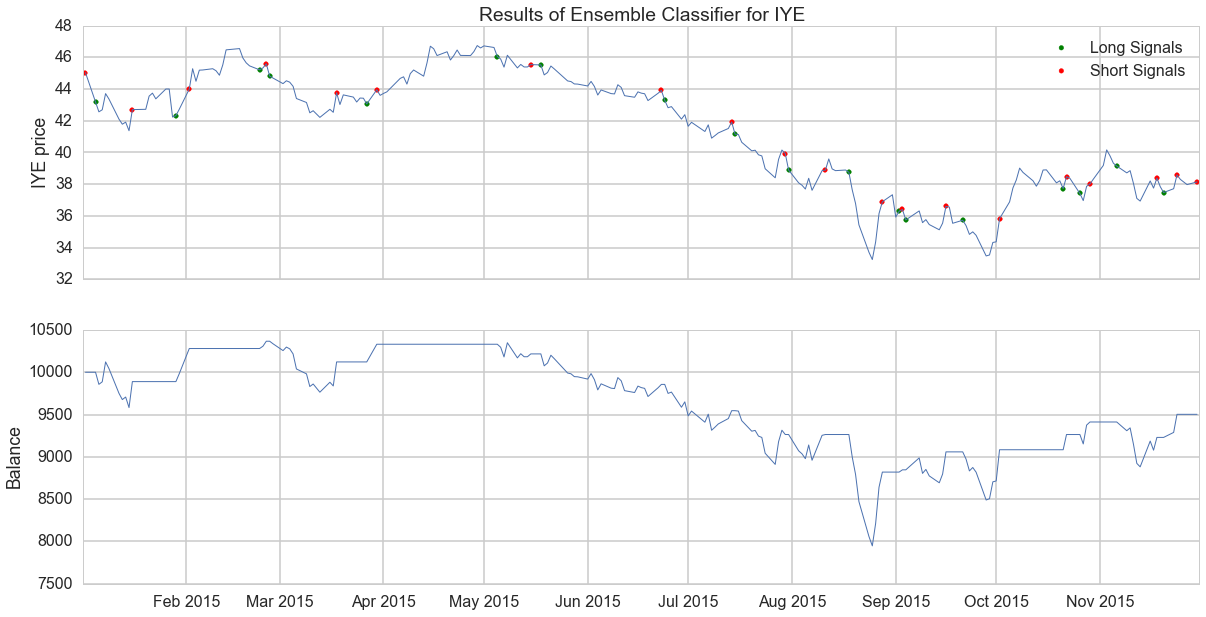

In [363]:
def plot_signal(model, title):
    fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10),sharex=True)
    ax0.plot(df.date[~mask], df.close[~mask], lw=1)
    short_days=zip(*evaluate(model)[5][0])[0]
    short_prices=zip(*evaluate(model)[5][0])[1]
    long_days=zip(*evaluate(model)[5][1])[0]
    long_prices=zip(*evaluate(model)[5][1])[1]
    ax0.scatter(long_days, long_prices, color='g', label="Long Signals") 
    ax0.scatter(short_days, short_prices, color='r', label="Short Signals")
    ax0.legend(frameon=False, loc='upper right')
    ax0.set_title(title)
    ax0.set_ylabel(ticker + " price")
    
    ax1.plot(zip(*evaluate(model)[6])[0], zip(*evaluate(model)[6])[1], lw=1)
    ax1.set_ylabel("Balance")
plot_signal(eclf, 'Results of Ensemble Classifier for '+ticker)

In [364]:
# Save results for this ticker to a JSON file
import json
fd = open("../ML_results/"+ticker+".json","w")
json.dump(Results, fd)
fd.close()

In [384]:
# Load results from all files
import glob
result_files = glob.glob("../ML_results/*.json")
print result_files
accuracies_all= {}
ROI_diff_all={}
for aFile in result_files:
    file_tickr = aFile[14:17]
    #print file_tickr
    with open(aFile, "r") as fd:
        result_dict = json.load(fd)
        models_acc = {}
        models_ROI_diff = {}
        for key, value in result_dict.iteritems():
            models_acc[key] =  value[1]
            models_ROI_diff[key] =  value[3]-value[2]
            accuracies_all[file_tickr] =  models_acc
            ROI_diff_all[file_tickr] =  models_ROI_diff
accuracies_all=pd.DataFrame(accuracies_all)
ROI_diff_all=pd.DataFrame(ROI_diff_all)

['../ML_results/ITB.json', '../ML_results/IYE.json', '../ML_results/IYH.json', '../ML_results/IYM.json', '../ML_results/IYR.json', '../ML_results/IYW.json', '../ML_results/IYZ.json']


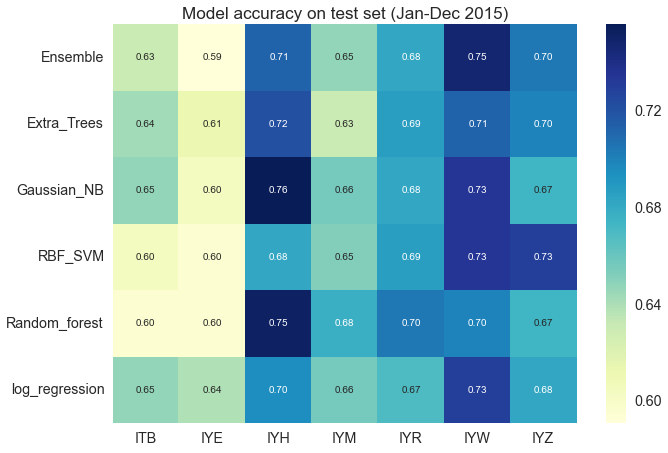

In [391]:
sns.set_context("talk", font_scale=1.1, rc={"lines.linewidth": 2.5})
ax = sns.heatmap(accuracies_all, annot=True, fmt='.2f',cmap="YlGnBu")
ax.set_title("Model accuracy on test set (Jan-Dec 2015)")

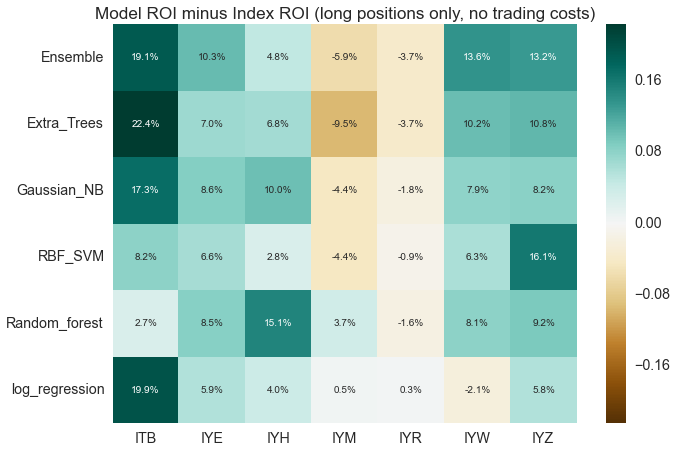

In [392]:
ax2 = sns.heatmap(ROI_diff_all, annot=True, fmt='.1%',cmap="BrBG")
ax2.set_title("Model ROI minus Index ROI (long positions only, no trading costs)")